Homomorphic convolution demo on audio
=====================================

Steps
-----
1.  Generate an audio test signal and a smoothing filter.
2.  Play the raw signal so you can hear it.
3.  Plot the signal and the filter.
4.  Encrypt (encode) them with Fourier‑CKKS.
5.  Plot *flattened* ciphertext coefficients so you can “see” what was encrypted.
6.  Perform homomorphic convolution (cipher_conv).
7.  Plot the encrypted result.
8.  Decrypt, plot, and play the recovered signal.
9.  Verify equality with a direct convolution computed in the clear.

In [1]:
from FourierCKKS import *
from util.ciphertext import Ciphertext
from collections.abc import Iterable
import matplotlib.pyplot as plt
from IPython.display import Audio, display

# Helper Functions

In [2]:
def _ct_to_array(ct):
    """
    Convert ONE Ciphertext → 1‑D real numpy array of concatenated
    c0 | c1 coefficients (dropping tiny imaginary parts).
    """
    def poly_to_arr(poly):
        # Try .coeffs first (common in Polynomial classes); fall back to np.asarray
        try:
            coeffs = np.asarray(poly.coeffs)
        except AttributeError:
            coeffs = np.asarray(poly)
        return np.real_if_close(coeffs).ravel()      # remove ~0j, flatten

    return np.concatenate([poly_to_arr(ct.c0), poly_to_arr(ct.c1)])

def flatten_ct(container):
    """
    Recursively walk through a (possibly nested) container that
    holds Ciphertext objects and return **one** flattened 1‑D array.
    """
    # Base case: the container *is* a Ciphertext
    if isinstance(container, Ciphertext):
        return _ct_to_array(container)

    # If the container is iterable (e.g. list/tuple), recurse
    if isinstance(container, Iterable):
        pieces = [flatten_ct(item) for item in container]
        return np.concatenate(pieces) if pieces else np.array([], dtype=float)

    # Anything else is unexpected
    raise TypeError(f"Unsupported element inside container: {type(container)}")

def play_ciphertext(flat_arr, fs=44_100):
    if flat_arr.size == 0:
        print("Ciphertext is empty!")
        return
    # Scale to <= ±1
    audio_vec = flat_arr / (np.max(np.abs(flat_arr)) + 1e-12)
    display(Audio(audio_vec, rate=fs))

# 1)  Generate audio + smoothing filter                                          

In [3]:
fs        = 3000                     # sample rate [Hz]
duration  = 1.0                        # [s]
t         = np.linspace(0, duration, int(fs * duration), endpoint=False)

signal_x  = np.sin(2*np.pi*440*t) + 0.1*np.random.randn(len(t))   # 440 Hz + white noise

filter_sz = 101
filter_h  = np.ones(filter_sz) / filter_sz                       # simple moving‑average

# 2)  Listen to the raw signal

In [4]:
print("▶ Original (noisy) 440 Hz tone")
display(Audio(signal_x, rate=fs))

▶ Original (noisy) 440 Hz tone


# 3)  Plot signal and filter

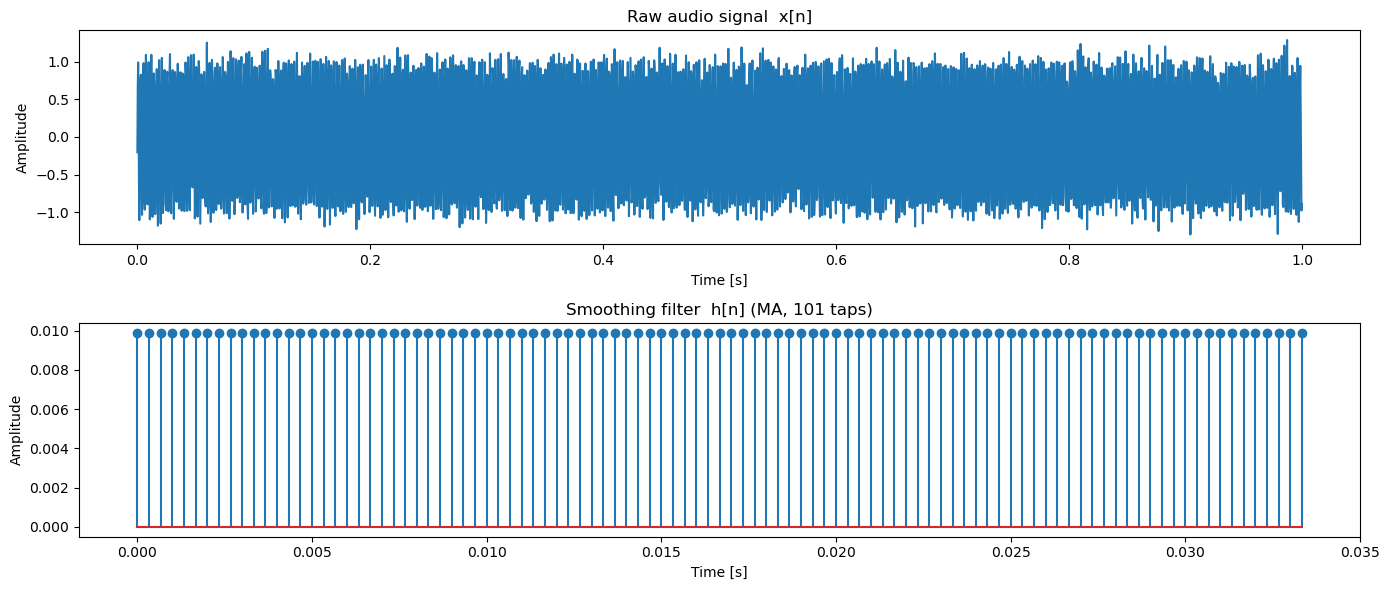

In [5]:
plt.figure(figsize=(14, 6))

plt.subplot(2, 1, 1)
plt.plot(t, signal_x)
plt.title("Raw audio signal  x[n]")
plt.ylabel("Amplitude")
plt.xlabel("Time [s]")

plt.subplot(2, 1, 2)
plt.stem(np.arange(filter_sz) / fs, filter_h)      # ← no use_line_collection
plt.title(f"Smoothing filter  h[n] (MA, {filter_sz} taps)")
plt.ylabel("Amplitude")
plt.xlabel("Time [s]")

plt.tight_layout()
plt.show()


# 4)  Encrypt signal and filter

In [6]:
fcks = FourierCKKS(is_parallel=False)

conv_len = len(signal_x) + len(filter_h) - 1      # length after linear conv

# encode / encrypt
ct_x = fcks.forward(signal_x.reshape(-1, 1), target_height=conv_len, target_width=1)
print("Encrypted the signal")
ct_h = fcks.forward(filter_h.reshape(-1, 1), target_height=conv_len, target_width=1)

PARALLEL!!!!!!
Encrypted the signal


# 5)  Plot flattened ciphertext values

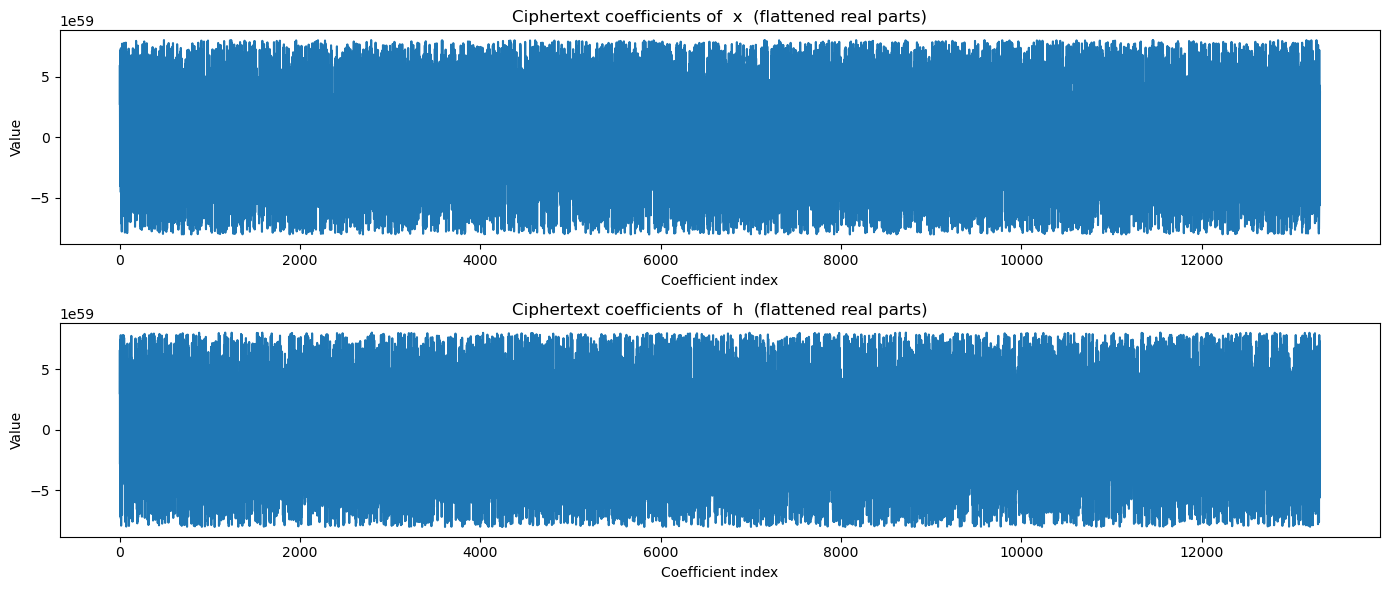

In [7]:
plt.figure(figsize=(14, 6))

plt.subplot(2, 1, 1)
plt.plot(flatten_ct(ct_x))
plt.title("Ciphertext coefficients of  x  (flattened real parts)")
plt.ylabel("Value")
plt.xlabel("Coefficient index")

plt.subplot(2, 1, 2)
plt.plot(flatten_ct(ct_h))
plt.title("Ciphertext coefficients of  h  (flattened real parts)")
plt.ylabel("Value")
plt.xlabel("Coefficient index")

plt.tight_layout()
plt.show()


In [8]:
print("\n▶ Playing ciphertext of x")
play_ciphertext(flatten_ct(ct_x))


▶ Playing ciphertext of x


# 6)  Homomorphic convolution 

In [9]:
ct_y = fcks.cipher_conv(ct_x, ct_h)

# 7)  Plot encrypted convolution result

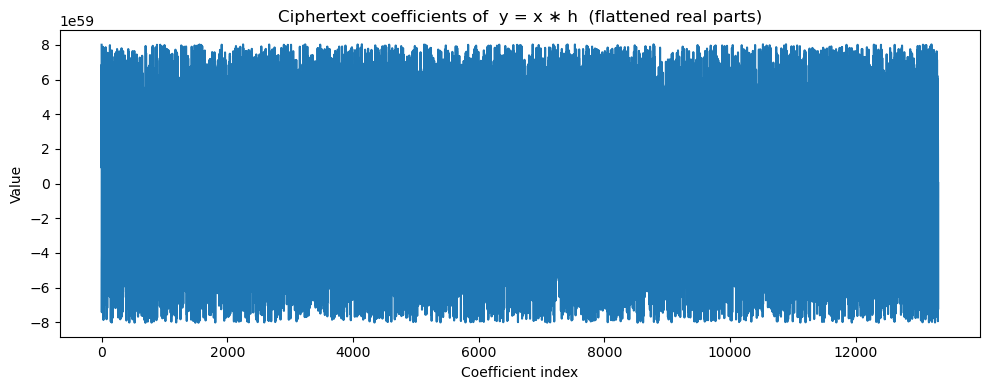

In [10]:
plt.figure(figsize=(10, 4))
plt.plot(flatten_ct(ct_y))
plt.title("Ciphertext coefficients of  y = x ∗ h  (flattened real parts)")
plt.ylabel("Value")
plt.xlabel("Coefficient index")
plt.tight_layout()
plt.show()

In [11]:
print("\n▶ Playing ciphertext of x")
play_ciphertext(flatten_ct(ct_y))


▶ Playing ciphertext of x


# 8)  Decrypt → listen + plot

▶ Decrypted (filtered) signal


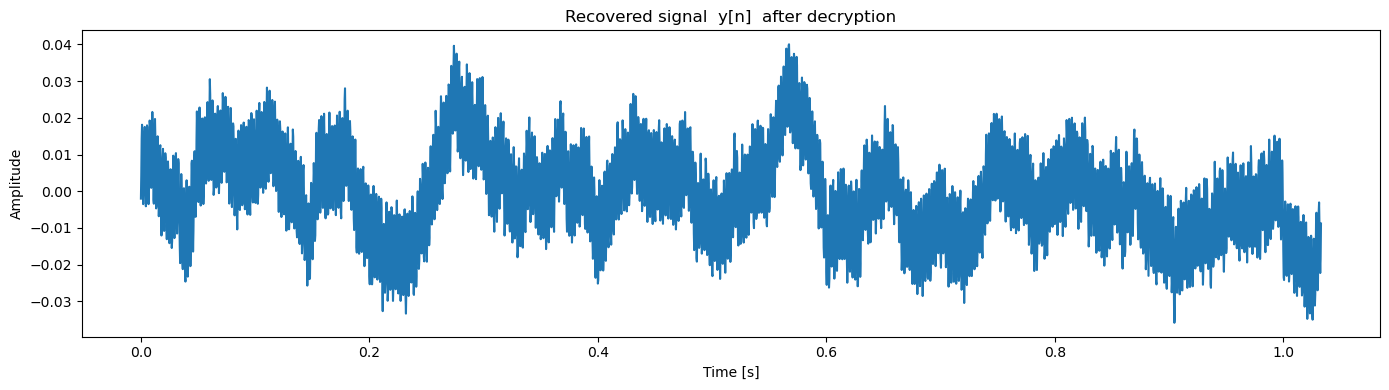

In [12]:
y_dec = fcks.backward(ct_y, target_height=conv_len, target_width=1).real
t_conv = np.linspace(0, duration + (filter_sz-1)/fs, conv_len, endpoint=False)

print("▶ Decrypted (filtered) signal")
display(Audio(y_dec, rate=fs))

plt.figure(figsize=(14, 4))
plt.plot(t_conv, y_dec, label="Decrypted homomorphic conv")
plt.title("Recovered signal  y[n]  after decryption")
plt.ylabel("Amplitude")
plt.xlabel("Time [s]")
plt.tight_layout()
plt.show()

# 9)  Ground‑truth comparison

Equality check (direct vs homomorphic): True


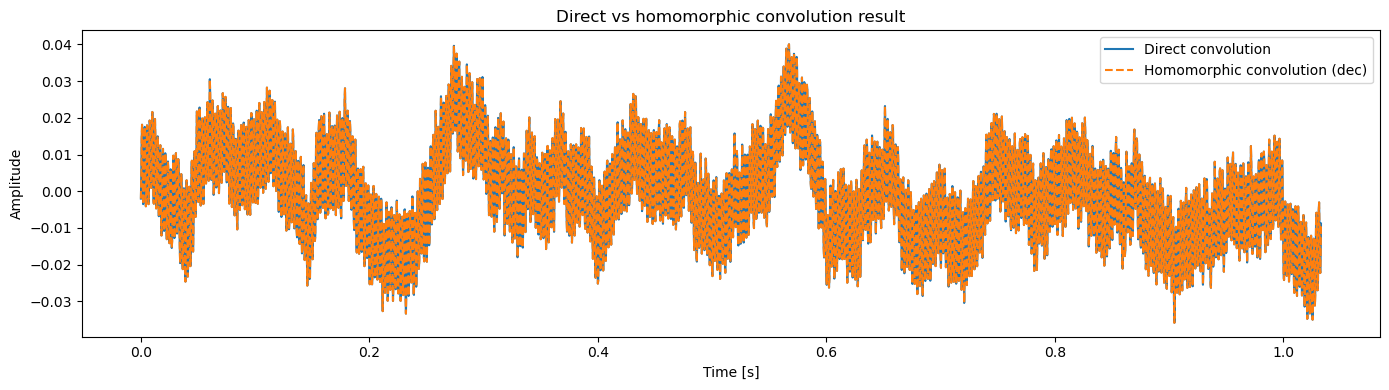

In [13]:
y_direct = linear_convolution_direct(signal_x, filter_h)

print("Equality check (direct vs homomorphic):",
      np.allclose(y_dec, y_direct, atol=1e-1))   # CKKS introduces ~1e‑1 error

plt.figure(figsize=(14, 4))
plt.plot(t_conv, y_direct, label="Direct convolution")
plt.plot(t_conv, y_dec, "--", label="Homomorphic convolution (dec)")
plt.legend()
plt.title("Direct vs homomorphic convolution result")
plt.ylabel("Amplitude")
plt.xlabel("Time [s]")
plt.tight_layout()
plt.show()
